In [1]:
from __future__ import print_function

import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='0'#'3'  #'0'
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from keras.preprocessing import image

import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')
 
import time

# Code for avoiding keras + tensorflow from using all memory:
# Similar to the solution above, but also need to manually setup the session on Keras back-end:
import tensorflow as tf
#config = tf.ConfigProto(device_count = {'GPU': 0})
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
import keras.backend.tensorflow_backend as tf_bkend
tf_bkend.set_session(sess)

#import utils_cnn
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
#import appendDataExam
#import utils
#from keras.layers import Lambda
from keras.layers.normalization import BatchNormalization
import pydot
from keras import optimizers

Using TensorFlow backend.


In [2]:
#capture paths to images
face_images = glob.glob('/home/Documents/code/Tutorials/datasets/lfw/**/*.jpg')
print("face_images is:", face_images)

face_images is: ['/home/an84020/Documents/code/Tutorials/datasets/lfw/Jose_Luis_Santiago_Vasconcelos/Jose_Luis_Santiago_Vasconcelos_0001.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Corey_Maggette/Corey_Maggette_0001.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Selma_Phoenix/Selma_Phoenix_0001.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Brandon_Robinson/Brandon_Robinson_0001.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Richard_Shelby/Richard_Shelby_0002.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Richard_Shelby/Richard_Shelby_0001.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Chuck_Eidson/Chuck_Eidson_0001.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Ralf_Schumacher/Ralf_Schumacher_0006.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Ralf_Schumacher/Ralf_Schumacher_0001.jpg', '/home/an84020/Documents/code/Tutorials/datasets/lfw/Ralf_Schumacher/Ralf_Schumacher_0008.jpg', '/home/

In [3]:
'''
Load data
'''
all_images = []
for i in tqdm(face_images):
    img = image.load_img(i, target_size=(80,80,3))
    img = image.img_to_array(img)
    img = img/255.
    all_images.append(img)

100%|██████████| 13233/13233 [00:13<00:00, 948.40it/s]


In [4]:
'''
Data Preparation for Model Training
'''

all_images = np.array(all_images)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, random_state=32, test_size=0.1)
print("train_x shape:",train_x.shape)

train_x shape: (11909, 80, 80, 3)


In [5]:
# function to reduce image resolution while keeping the image size constant

def pixalate_image(image, scale_percent = 40):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    small_image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  
    # scale back to original size
    width = int(small_image.shape[1] * 100 / scale_percent)
    height = int(small_image.shape[0] * 100 / scale_percent)
    dim = (width, height)

    low_res_image = cv2.resize(small_image, dim, interpolation = cv2.INTER_AREA)

    return low_res_image

In [6]:
# get low resolution images for the training set
train_x_px = []

for i in range(train_x.shape[0]):
    temp = pixalate_image(train_x[i,:,:,:])
    train_x_px.append(temp)

train_x_px = np.array(train_x_px)


# get low resolution images for the validation set
val_x_px = []

for i in range(val_x.shape[0]):
    temp = pixalate_image(val_x[i,:,:,:])
    val_x_px.append(temp)

val_x_px = np.array(val_x_px)

In [9]:
'''
Build Model
'''

Input_img = Input(shape=(80, 80, 3))  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 80, 80, 256)       7168      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 80, 80, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 40, 40, 64)        73792     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 64)        36928     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 80, 80, 64)        0   

In [10]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')

a_e = autoencoder.fit(train_x_px, train_x,
            epochs=50,
            batch_size=50,  #256,
            shuffle=True,
            validation_data=(val_x_px, val_x),
            callbacks=[early_stopper])

Train on 11909 samples, validate on 1324 samples
Epoch 1/50
11909/11909 [==============================] - 61s 5ms/sample - loss: 0.0142 - val_loss: 0.0037
Epoch 2/50
11909/11909 [==============================] - 57s 5ms/sample - loss: 0.0031 - val_loss: 0.0029
Epoch 3/50
11909/11909 [==============================] - 57s 5ms/sample - loss: 0.0028 - val_loss: 0.0027
Epoch 4/50
11909/11909 [==============================] - 57s 5ms/sample - loss: 0.0030 - val_loss: 0.0028
Epoch 5/50
11909/11909 [==============================] - 57s 5ms/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 6/50
11909/11909 [==============================] - 57s 5ms/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 7/50
11909/11909 [==============================] - 57s 5ms/sample - loss: 0.0025 - val_loss: 0.0025
Epoch 8/50
11909/11909 [==============================] - 58s 5ms/sample - loss: 0.0026 - val_loss: 0.0024
Epoch 9/50
11909/11909 [==============================] - 57s 5ms/sample - loss: 0.0025 - val_l

In [11]:
predictions = autoencoder.predict(val_x_px)

W0419 15:10:34.134844 140303455696704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0419 15:10:34.242215 140303455696704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0419 15:10:34.256863 140303455696704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0419 15:10:34.270066 140303455696704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0419 15:10:34.284471 140303455696704 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


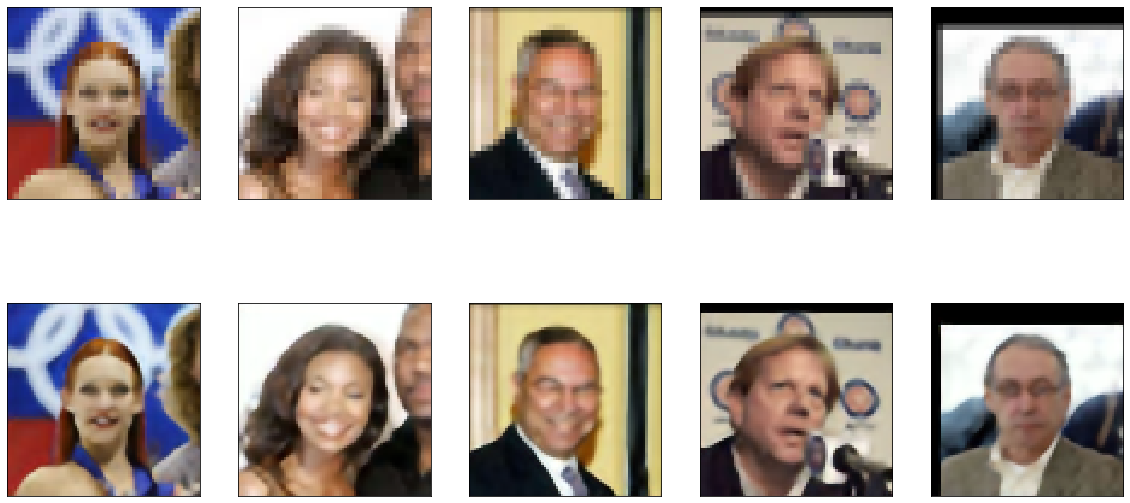

In [12]:
n = 5
plt.figure(figsize= (20,10))

for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(val_x_px[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(predictions[i+20])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()